In [1]:
import requests 
from urllib.request import urlopen

from datetime import datetime
import time # time.sleep(n)

from bs4 import BeautifulSoup # HTTP Response -> HTML 
import pandas as pd
import re
import datetime
import nltk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 위치를 넣어주세요 (위에서 나눔고딕 파일을 해당 경로에 복사붙여넣기 했을 경우 그대로 실행하셔도 무방합니다.)
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)

In [2]:
query = '국제유가'
url = "https://search.naver.com/search.naver?where=nexearch&query=" + query

In [3]:
import requests 
web = requests.get(url).content

In [4]:
web = requests.get(url).content
source = BeautifulSoup(web, 'html.parser')

In [6]:
test_date = datetime.datetime.now()
print(test_date)

2020-11-11 10:16:01.092462


In [5]:
def News_crawl():
    query = '국제유가'
    url = "https://search.naver.com/search.naver?where=news&query=" + query
    web = requests.get(url).content
    source = BeautifulSoup(web, 'html.parser')
    
    # 시작과 끝 날짜 지정
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=3)
    end_date = end_date.strftime('%Y-%m-%d')
    end_date = str(end_date).replace("-",".")
    start_date = start_date.strftime('%Y-%m-%d')
    start_date = str(start_date).replace("-",".")
    
    # 크롤링을 원하는 최대 페이지 수 지정
    max_page = 5 
    
    # 각 기사들의 데이터를 종류별로 나눠담을 리스트를 생성합니다. (추후 DataFrame으로 모을 예정)
    titles = []
    dates = []
    articles = []
    article_urls = []
    press_companies = []


    # 주어진 일자를 쿼리에 맞는 형태로 변경해줍니다.
    start_date = start_date.replace(".", "")
    end_date = end_date.replace(".", "")

    # 지정한 기간 내 원하는 페이지 수만큼의 기사를 크롤링합니다.
    current_call = 1
    last_call = (max_page - 1) * 10 + 1 # max_page이 5일 경우 41에 해당 

    while current_call <= last_call:

        print('\n{}번째 기사글부터 크롤링을 시작합니다.'.format(current_call))

        url = "https://search.naver.com/search.naver?where=news&query=" + query \
              + "&docid=&nso=so%3Ar%2Cp%3Afrom" + start_date \
              + "to" + end_date \
              + "%2Ca%3A&start=" + str(current_call)


        web = requests.get(url).content
        source = BeautifulSoup(web, 'html.parser')

        urls_list = []
        for urls in source.find_all('a', {'class' : "info"}):
            if urls["href"].startswith("https://news.naver.com"):
                urls_list.append(urls["href"])

        for url in urls_list:
            try:
                headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}
                web_news = requests.get(url, headers=headers).content
                source_news = BeautifulSoup(web_news, 'html.parser')

                title = source_news.find('h3', {'id' : 'articleTitle'}).get_text()
                print('Processing article : {}'.format(title))

                date = source_news.find('span', {'class' : 't11'}).get_text()

                article = source_news.find('div', {'id' : 'articleBodyContents'}).get_text()
                article = article.replace("\n", "")
                article = article.replace("// flash 오류를 우회하기 위한 함수 추가function _flash_removeCallback() {}", "")
                article = article.replace("동영상 뉴스       ", "")
                article = article.replace("동영상 뉴스", "")
                article = article.strip()

                press_company = source_news.find('address', {'class' : 'address_cp'}).find('a').get_text()

                titles.append(title)
                dates.append(date)
                articles.append(article)
                press_companies.append(press_company)
                article_urls.append(url)
            except:
                print('*** 다음 링크의 뉴스를 크롤링하는 중 에러가 발생했습니다 : {}'.format(url))

        # 대량의 데이터를 대상으로 크롤링을 할 때에는 요청 사이에 쉬어주는 타이밍을 넣는 것이 좋습니다.
        time.sleep(5)
        current_call += 10


    # 각 데이터 종류별 list에 담아둔 전체 데이터를 DataFrame에 모으고 엑셀 파일로 저장합니다.
    # 파일명을 result_연도월일_시분.csv 로 지정합니다.
    article_df = pd.DataFrame({'Title':titles, 
                               'Date':dates, 
                               'Article':articles, 
                               'URL':article_urls, 
                               'PressCompany':press_companies})

    article_df.to_excel('result_{}.xlsx'.format(datetime.datetime.now().strftime('%y%m%d_%H%M')), index=False, encoding='utf-8')
    article_df.head()

In [161]:
# 네이버 일별 석유 데이터 불러오기
w_oil1 = source.find_all('span', {'class' : 'flu_nm' })[0].get_text()
w_oil2 = source.find_all('span', {'class' : 'flu_nm' })[1].get_text()
w_oil3 = source.find_all('span', {'class' : 'flu_nm' })[2].get_text()

# 데이터 정리
w_oil1 = w_oil1[-8:-3]
w_oil2 = w_oil2[-8:-3]
w_oil3 = w_oil3[-8:-3]
    
# 평균 계산
w_oilm = float(w_oil1) + float(w_oil2) + float(w_oil3)
w_oilm = w_oilm/3

# 평균 비교 후 뉴스 크롤링 체크
if -2 <= w_oilm <= 2:
    qust = input("유가 변동 폭이 적습니다. 그래도 진행 하시겠습니까? (y/n)")
    if qust == 'y':
        News_crawl()
    else:
        print("다음 단계로 넘어갑니다.")
else:
    News_crawl()



1번째 기사글부터 크롤링을 시작합니다.
Processing article : 美 바이든 시대, 통상 리스크 줄고 反中동맹 연대 압박…유가↑· 환율↓
Processing article : 코로나 급증에 놀란 국제유가…WTI 4.3% 급락
Processing article : [이번주 유가 동향]국내 휘발윳값 11주째 하락…1322.2원
Processing article : 바이든 승리 유력에 금값 2.7% '급등'…유가는 하락
Processing article : 바이든 승리, 금리·주식 오르고 유가는 내린다

11번째 기사글부터 크롤링을 시작합니다.
Processing article : 하룻새 12만명…美 코로나 환자 폭증에 유가 4%↓
Processing article : [국제유가] 바이든, 사실상 승기에 금값 50달러 급등… WTI는 0.9%↓

21번째 기사글부터 크롤링을 시작합니다.
Processing article : 바이든 당선시 韓 수출 '청신호'..태양광·배터리 수요 늘것
Processing article : [이슈분석] 美대선, 개표 여정에 첫 마침표…바이든 당선 ‘확정’
Processing article : [바이든 시대] 韓 태양광 빛 본다… LG·SK 배터리 소송은 여전히 안갯속
Processing article : 정부가 묻어둔 '태양광 청구서'…"투명하게 공개하라"

31번째 기사글부터 크롤링을 시작합니다.
Processing article : 세금 더 걷어 친환경·인프라 집중 투자
Processing article : 美 증시 혼조, 4거래일 상승 뒤 숨고르기 [뉴욕증시]
Processing article : 美 '바이든 시대' 열렸다…국내 경제 미칠 영향은?
Processing article : [바이든 시대] '바이든노믹스'도 美우선·탈중국이 핵심… "韓, 고래 싸움에 낀 새우 신세 계속될 듯"
Processing article : 미국 증시, 바이든 승기 '안도'…나스닥 2.6% 급등
Processing article : 정

In [88]:
# 크롤링 데이터 분석
from konlpy.tag import Twitter

# 엑셀 데이터 불러오고 타이틀 하나의 str로 묶기
df = pd.read_excel('result_201109_1206.xlsx', encoding='utf-8')
titles = df['Title'].tolist()
titles = ' '.join(titles)
titles[:1000]

# 품사별로 분류
twitter = Twitter()
raw_pos_tagged = twitter.pos(titles, norm=True, stem=True) # POS Tagging
raw_pos_tagged

# 무의미한 품사 정리(필터링)
del_list = ['하다', '고르다', '미치다', '있다', '되다', '이다', '돼다', '않다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다', '11'] 

word_cleaned = []

for word in raw_pos_tagged: 
    if word[1] not in ["Josa", "Eomi", "Punctuation", "Foreign"]: # Foreign == ”, “ 와 같이 제외되어야할 항목들
        if (len(word[0]) != 1) & (word[0] not in del_list): # 한 글자로 이뤄진 단어들을 제외 & 원치 않는 단어들을 제외
            word_cleaned.append(word[0])

from collections import Counter

result = Counter(word_cleaned)
word_dic = dict(result)

# 키워드들의 밸류값에 횟수 넣기
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)

# 토큰화
word_frequency = nltk.FreqDist(word_cleaned) # Frequency Distribution

# 딕트로 데이터 프레임 생성
df = pd.DataFrame(list(word_frequency.values()), word_frequency.keys()) 
result = df.sort_values([0], ascending=False)

# 상위 16개 선정
result = result[:25]

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


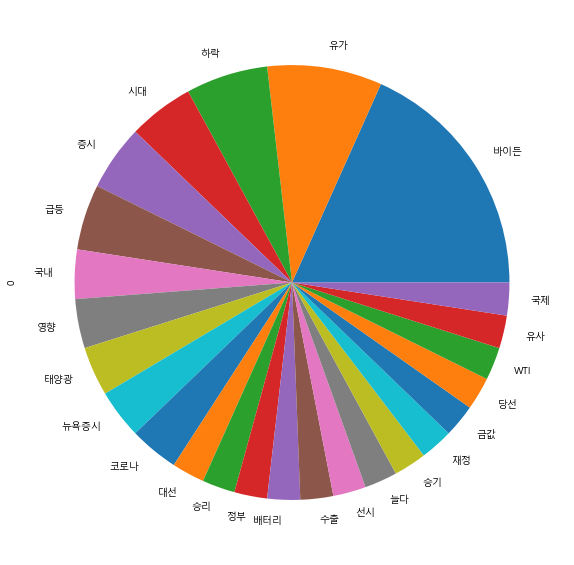

In [85]:
# 파이 그래프 표현
result.plot(kind='pie', subplots=True, legend=False, figsize=(10,10))
plt.show()

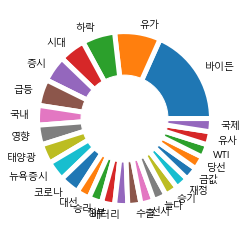

In [90]:
# 파스텔 색상을 위한 준비
# from palettable.colorbrewer.qualitative import Pastel1_7

# 행과 열의 키값 추가
result = result.reset_index()

names = list(result['index'])
size = list(result[0])

# linewidth 값 수치 조정을 통해 데이터간의 간격 크기 조절
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' })

# # 파스텔 색상 라이브러리 설치 완료시
# plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors)
p = plt.gcf()

# plt 안에 '흰색'의 원을 덮어 씌워 도넛 모양을 만든다
my_circle = plt.Circle( (0,0), 0.5, color='white')

p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# 도넛형 차트 참고 값
# # Give color names
# plt.pie(size, labels=names, colors=['red','green','blue','skyblue'])
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()
 
# # Custom colors --> colors will cycle
# plt.pie(size, labels=names, colors=['red','green'])
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()
 
# from palettable.colorbrewer.qualitative import Pastel1_7
# plt.pie(size, labels=names, colors=Pastel1_7.hex_colors)
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

# # Label distance: gives the space between labels and the center of the pie
# plt.pie(size, labels=names, labeldistance=0.45)
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()
 
# # Label color
# plt.rcParams['text.color'] = 'red'
# plt.pie(size, labels=names)
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()
